<a href="https://colab.research.google.com/github/f10r3nz4/Significance/blob/main/Progetto_CV_DL_PyTorch_Task1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Collegamento al dataset

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


Librerie importate

In [ ]:
!pip install efficientnet_pytorch
import copy
import time
import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
from torchvision import datasets, transforms, models
from PIL import Image
from torch.autograd import Variable
from torch.utils.data import Dataset
import os
import numpy as np
import pandas as pd
import seaborn as sns
from torchvision.io import read_image
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
from efficientnet_pytorch import EfficientNet
from sklearn.metrics import classification_report

Caricamento immagini, augmentation, shuffling, holdout

In [ ]:
def load_train_test(datadir_t, datadir_v, batchsize, valid_size = .2):
    train_transforms = transforms.Compose([transforms.RandomRotation(30),
                                       transforms.Resize([1024, 1024]), #h x w
                                       transforms.RandomHorizontalFlip(),
                                       transforms.RandomVerticalFlip(),
                                       transforms.ToTensor(),
                                       transforms.Normalize([0.485, 0.456, 0.406],
                                                            [0.229, 0.224, 0.225])
                                       
                                       ])

    val_transforms = transforms.Compose([transforms.Resize([1024,1024]),
                                         transforms.ToTensor(),
                                         transforms.Normalize([0.485, 0.456, 0.406],
                                                              [0.229, 0.224, 0.225])
                                      ])

    train_data = datasets.ImageFolder(datadir_t, transform=train_transforms)
    val_data = datasets.ImageFolder(datadir_v, transform=val_transforms)

    trainloader = torch.utils.data.DataLoader(train_data, batch_size=batchsize, shuffle=True)
    valloader = torch.utils.data.DataLoader(val_data, batch_size=batchsize, shuffle=True)
    return trainloader, valloader

In [ ]:
# Scelta del modello [resnet18, resnet50, vgg16, vgg11, densenet, efficientnet]
model_name = "resnet50"

# Numero di classi
num_classes = 2

# Batch size per training
batch_size = 32

# Numero di epoche
num_epochs = 20

# Falso, finetuning dell'intero modello,
# Vero solo aggiornamento dei reshaped layer params
feature_extract = True

In [ ]:
data_dir_train = '/content/gdrive/My Drive/CV-DL/PROGETTO/Classificazione1/Dataset/Train/'
data_dir_val = '/content/gdrive/My Drive/CV-DL/PROGETTO/Classificazione1/Dataset/Validation/'

trainloader, valloader = load_train_test(data_dir_train, data_dir_val, batch_size)

print(trainloader.dataset.classes)

['Coins', 'Icons']


Definizione training e validation

In [ ]:
def train_model(model, train_loader, test_loader, criterion, optimizer, num_epochs):
    since = time.time()

    val_acc_train = []
    val_loss_train = []
    val_acc_test = []
    val_loss_test = []

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
      print('Epoch {}/{}'.format(epoch, num_epochs - 1))
      print('-' * 10)

      #Modello impostato su train
      model.train()
                
      running_loss = 0.0
      running_corrects = 0

      # Iterazione sui dati
      for inputs, labels in train_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        # zero parameter gradients
        optimizer.zero_grad()
                
        with torch.set_grad_enabled(True):
          outputs = model(inputs)
          loss = criterion(outputs, labels)

          _, preds = torch.max(outputs, 1)

          #backward + optimize
          loss.backward()
          optimizer.step()

        #statistiche
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)

      train_loss = running_loss / len(train_loader.dataset)
      train_acc = running_corrects.double() / len(train_loader.dataset)


      val_acc_train.append(train_acc)
      val_loss_train.append(train_loss)
          

      print('{} Loss: {:.4f} Acc: {:.4f}'.format('Training', train_loss, train_acc))

      #Modello impostato su validation
      model.eval() 

      running_loss = 0.0
      running_corrects = 0

      for inputs, labels in test_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        with torch.set_grad_enabled(False):        
          outputs = model(inputs)
          loss = criterion(outputs, labels)

          _, preds = torch.max(outputs, 1)

        # statistiche
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)

      test_loss = running_loss / len(test_loader.dataset)
      test_acc = running_corrects.double() / len(test_loader.dataset)
            
      if test_acc > best_acc:
        best_acc = test_acc
        best_model_wts = copy.deepcopy(model.state_dict())

      val_acc_test.append(test_acc)
      val_loss_test.append(test_loss)

      print('{} Loss: {:.4f} Acc: {:.4f}'.format('Validation', test_loss, test_acc))
            

      print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best Validation Acc: {:4f}'.format(best_acc))

    #restituisce il modello con i pesi migliori
    model.load_state_dict(best_model_wts)
    return model, val_acc_train, val_loss_train, val_acc_test, val_loss_test

Definizione modello

In [ ]:
def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False


def initialize_model(model_name, num_classes, feature_extract, use_pretrained=True):
    model_ft = None
    input_size = 0

    
    """ Resnet18"""
    if model_name == "resnet18":
        model_ft = models.resnet18(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(num_ftrs, num_classes)
        input_size = 1024
    
    """ Resnet50"""
    if model_name == "resnet50":
        model_ft = models.resnet50(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(num_ftrs, num_classes)
        input_size = 1024

    """ Densenet"""
    if model_name == "densenet":   
        model_ft = models.densenet121(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier.in_features
        model_ft.classifier = nn.Linear(num_ftrs, num_classes)
        input_size = 1024

    #vgg funziona con batch size di dimensione 8
    """ VGG11_bn"""
    if model_name == "vgg11":
          model_ft = models.vgg11_bn(pretrained=use_pretrained)
          set_parameter_requires_grad(model_ft, feature_extract)
          num_ftrs = model_ft.classifier[6].in_features
          model_ft.classifier[6] = nn.Linear(num_ftrs,num_classes)
          input_size = 1024

    """ VGG16"""
    if model_name == "vgg16":
          model_ft = models.vgg16(pretrained=use_pretrained)
          set_parameter_requires_grad(model_ft, feature_extract)
          num_ftrs = model_ft.classifier[6].in_features
          model_ft.classifier[6] = nn.Linear(num_ftrs,num_classes)
          input_size = 1024

    """ EfficientNet"""
    if model_name == "efficientnet":
          input_size = 1024
          model_ft = EfficientNet.from_pretrained('efficientnet-b0', image_size=input_size, num_classes=num_classes)
          set_parameter_requires_grad(model_ft, feature_extract)
          num_ftrs = model_ft._fc.in_features
          model_ft._fc = torch.nn.Linear(num_ftrs, num_classes) 

    else:
        print("Invalid model name, exiting...")
        exit()

    return model_ft, input_size

# Inizializzazione del modello
model_ft, input_size = initialize_model(model_name, num_classes, feature_extract, use_pretrained=True)

# Stampa del modello
print(model_ft)

Invalid model name, exiting...
ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, 

Esecuzione Training e Validation

In [ ]:
#Necessita di una macchina con GPU
device = torch.device('cuda:0')


# Modello inviato alla GPU
model_ft = model_ft.to(device)

params_to_update = model_ft.parameters()
print("Params to learn:")
if feature_extract:
    params_to_update = []
    for name,param in model_ft.named_parameters():
        if param.requires_grad == True:
            params_to_update.append(param)
            print("\t",name)
else:
    for name,param in model_ft.named_parameters():
        if param.requires_grad == True:
            print("\t",name)
            
# Optimizer
#optimizer_ft = optim.SGD(params_to_update, lr=0.001, momentum=0.9)
optimizer_ft = optim.Adam(params_to_update, lr=0.0001)

Params to learn:
	 fc.weight
	 fc.bias


In [ ]:
#Impostazione funzione loss
criterion = nn.CrossEntropyLoss()

# Train ed evaluate
model_ft, train_acc, train_loss, test_acc, test_loss = train_model(model_ft, trainloader, valloader, criterion, optimizer_ft, num_epochs=num_epochs)

Epoch 0/19
----------


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


Training Loss: 0.6671 Acc: 0.5887
Validation Loss: 0.6438 Acc: 0.4943

Epoch 1/19
----------
Training Loss: 0.5587 Acc: 0.6958
Validation Loss: 0.5492 Acc: 0.7368

Epoch 2/19
----------
Training Loss: 0.4689 Acc: 0.9803
Validation Loss: 0.4658 Acc: 0.9428

Epoch 3/19
----------
Training Loss: 0.3961 Acc: 0.9887
Validation Loss: 0.4121 Acc: 0.9497

Epoch 4/19
----------
Training Loss: 0.3309 Acc: 0.9972
Validation Loss: 0.3521 Acc: 0.9863

Epoch 5/19
----------
Training Loss: 0.2908 Acc: 0.9944
Validation Loss: 0.3225 Acc: 0.9703

Epoch 6/19
----------
Training Loss: 0.2600 Acc: 0.9887
Validation Loss: 0.2987 Acc: 0.9565

Epoch 7/19
----------
Training Loss: 0.2276 Acc: 1.0000
Validation Loss: 0.2454 Acc: 0.9954

Epoch 8/19
----------
Training Loss: 0.2230 Acc: 0.9915
Validation Loss: 0.2430 Acc: 0.9886

Epoch 9/19
----------
Training Loss: 0.2059 Acc: 0.9859
Validation Loss: 0.2559 Acc: 0.9519

Epoch 10/19
----------
Training Loss: 0.1852 Acc: 0.9972
Validation Loss: 0.2008 Acc: 0.9931

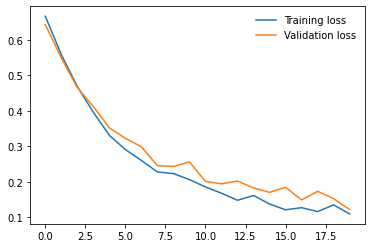

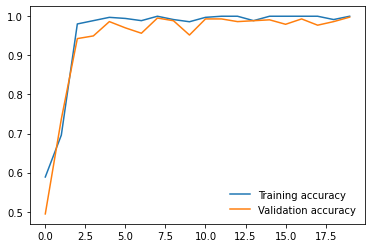

In [ ]:
#Stampa grafici di andamento accuracy e loss in train e validation
plt.plot(train_loss, label='Training loss')
plt.plot(test_loss, label='Validation loss')
plt.legend(frameon=False)
plt.show()

plt.plot(train_acc, label='Training accuracy')
plt.plot(test_acc, label='Validation accuracy')
plt.legend(frameon=False)
plt.show()

Stampa

In [ ]:
datadir = '/content/gdrive/My Drive/CV-DL/PROGETTO/Classificazione1/TestMatrix'

#Funzione per la stampa delle immagini
def imshow(img, title):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    i = 0
    fig=plt.figure(figsize=(10,10), tight_layout=True)
    for image, preds in zip(npimg, title.view(-1)):
     sub = fig.add_subplot(5, 5, i+1)
     i=i+1
     sub.set_title(classes[preds.item()])
     plt.axis('off')
     plt.imshow(np.transpose(image, (1, 2, 0)))
    plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

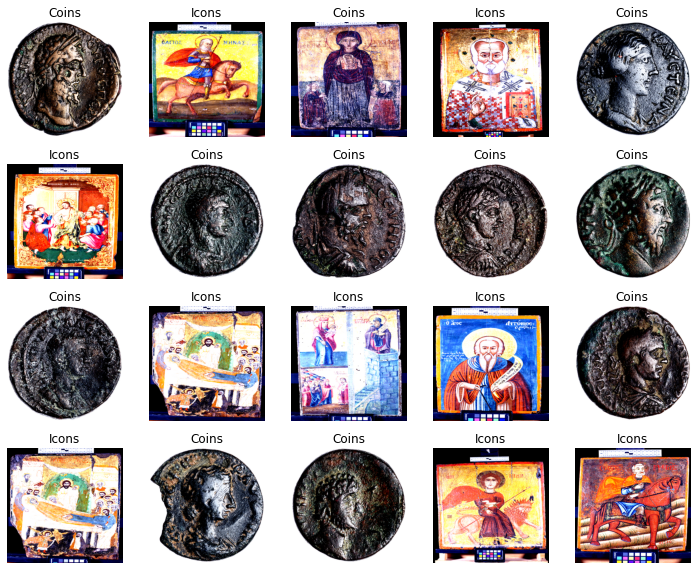

In [ ]:
test_transforms = transforms.Compose([transforms.Resize([1024,1024]),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406], 
                                                            [0.229, 0.224, 0.225])
                                      ])

testmatrix = datasets.ImageFolder(datadir, transform=test_transforms)

classes = trainloader.dataset.classes

model = model_ft
model.eval()
model 
subset_indices = []
quanity = 10
i=0
while i<10:
  subset_indices.append(i)
  subset_indices.append(i+200)
  i=i+1

subset = torch.utils.data.Subset(testmatrix, subset_indices)
matrixloader_subset = torch.utils.data.DataLoader(subset, batch_size=32, shuffle=True)
for image, label in matrixloader_subset:
  input = image.to(device)
  label = label.to(device)
  output = model(input)
  _, preds = torch.max(output, 1)
  imshow(image, preds)

Matrice di confusione

Text(0.5, 69.0, 'Classi predette')

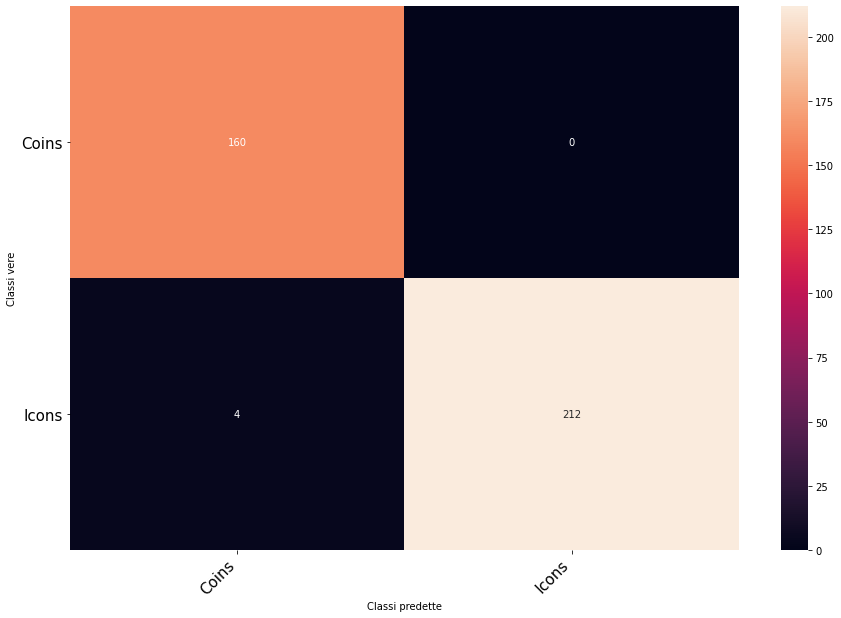

In [ ]:
#Caricamento dati per matrice di confusione
matrixloader = torch.utils.data.DataLoader(testmatrix, batch_size=batch_size, shuffle=True)

true_label = []
predicted_label = []

nb_classes = 2
confusion_matrix = np.zeros((nb_classes, nb_classes))
with torch.no_grad():
    for input, label in matrixloader:
        input = input.to(device)
        label = label.to(device)
        output = model(input)
        _, preds = torch.max(output, 1)
        for t, p in zip(label.view(-1), preds.view(-1)):
                confusion_matrix[t.long(), p.long()] += 1
                true_label.append(t.item())
                predicted_label.append(p.item())

plt.figure(figsize=(15, 10))
class_names = list(classes)
df_cm = pd.DataFrame(confusion_matrix, index=class_names, columns=class_names).astype(int)
heatmap = sns.heatmap(df_cm, annot=True, fmt="d")

heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right',fontsize=15)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right',fontsize=15)
plt.ylabel('Classi vere')
plt.xlabel('Classi predette')

Report Classificazione

In [ ]:
#Stampa dei report di classificazione
target_names = ['Coins', 'Icons']
print(classification_report(true_label, predicted_label, target_names=target_names, labels=[0, 1]))

              precision    recall  f1-score   support

       Coins       0.98      1.00      0.99       160
       Icons       1.00      0.98      0.99       216

    accuracy                           0.99       376
   macro avg       0.99      0.99      0.99       376
weighted avg       0.99      0.99      0.99       376



Salvataggio modello

In [ ]:
torch.save(model, '/content/gdrive/My Drive/CV-DL/PROGETTO/classification1.pth')